### Import Libs

In [475]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.encoding import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.selection import DropConstantFeatures
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

### Load Data

In [476]:
df = pd.read_csv('../processed_data/features-target.csv')

In [477]:
df.head()

,machineID,dtRef,volt_mean_1_days,volt_std_1_days,volt_min_1_days,volt_max_1_days,volt_max_rate_1_days,pressure_mean_1_days,pressure_std_1_days,pressure_min_1_days,...,days_since_last_error,days_since_last_rep,model,age,count_comp2_last15days,count_comp4_last15days,count_comp3_last15days,count_comp1_last15days,avg_days_between_mtn,target
0,1,2015-02-02,164.947744,12.526438,142.559604,190.985830,1.120290,100.862632,7.021747,87.529260,...,5.833333,12.75,model3,18,0.0,0.0,0.0,0.0,33.285714,0.0
1,2,2015-02-02,167.388450,17.700100,135.350069,216.299453,1.268775,99.735153,9.236172,81.742015,...,20.416667,14.75,model4,7,0.0,0.0,0.0,0.0,54.000000,0.0
2,3,2015-02-02,166.065714,13.018281,139.126762,192.111761,1.126894,100.077484,12.097118,78.093179,...,4.291667,10.75,model3,8,0.0,0.0,0.0,0.0,44.000000,1.0
3,4,2015-02-02,173.652648,12.136008,152.527285,192.391288,1.128534,100.701927,10.328765,81.286954,...,16.750000,15.75,model3,7,0.0,0.0,0.0,0.0,53.750000,0.0
4,5,2015-02-02,167.550151,13.873202,140.783515,195.575448,1.147212,102.314697,12.696205,76.244390,...,1.208333,8.75,model3,2,0.0,0.0,0.0,0.0,32.400000,0.0


The creation of the dataset is described in the notebook "pdm-exploration-features.ipynb".

### Data Description

In [478]:
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])

Number of rows: 31600
Number of columns: 97


In [479]:
df.dtypes

machineID                   int64
dtRef                      object
volt_mean_1_days          float64
volt_std_1_days           float64
volt_min_1_days           float64
                           ...   
count_comp4_last15days    float64
count_comp3_last15days    float64
count_comp1_last15days    float64
avg_days_between_mtn      float64
target                    float64
Length: 97, dtype: object

In [480]:
df.isna().sum()

machineID                 0
dtRef                     0
volt_mean_1_days          0
volt_std_1_days           0
volt_min_1_days           0
                         ..
count_comp4_last15days    0
count_comp3_last15days    0
count_comp1_last15days    0
avg_days_between_mtn      0
target                    0
Length: 97, dtype: int64

The variable "days_since_last_error/failure" should indicate if a variable had an error before or not. So, since it has nan values, we can assume machines that didn't have errors or failures and this value should be very high. This is a consideration for the pre-processing part.

In [481]:
df.describe()

,machineID,volt_mean_1_days,volt_std_1_days,volt_min_1_days,volt_max_1_days,volt_max_rate_1_days,pressure_mean_1_days,pressure_std_1_days,pressure_min_1_days,pressure_max_1_days,...,days_since_last_failure,days_since_last_error,days_since_last_rep,age,count_comp2_last15days,count_comp4_last15days,count_comp3_last15days,count_comp1_last15days,avg_days_between_mtn,target
count,31600.000000,31600.000000,31600.000000,31600.000000,31600.000000,31600.000000,31600.000000,31600.000000,31600.000000,31600.000000,...,29908.000000,31580.000000,31600.000000,31600.000000,31600.0,31600.0,31600.0,31600.0,31600.000000,31600.000000
mean,50.500000,170.760869,14.912348,141.446891,200.167114,1.174146,100.849249,10.053176,81.112933,120.645158,...,41.273556,9.717854,9.460032,11.330000,0.0,0.0,0.0,0.0,23.125695,0.132595
std,28.866527,4.722131,2.257656,8.309407,8.726679,0.051189,4.705546,1.718139,6.258213,7.246184,...,42.545864,9.332403,7.166314,5.827708,0.0,0.0,0.0,0.0,7.764057,0.339142
min,1.000000,157.745683,7.383772,97.333604,176.709005,1.036544,90.973896,4.513850,51.237106,101.486195,...,0.750000,0.000000,0.750000,0.000000,0.0,0.0,0.0,0.0,12.571429,0.000000
25%,25.750000,168.036829,13.343677,136.396166,194.093201,1.138517,98.682687,8.924697,77.553506,116.058943,...,12.750000,2.875000,4.750000,6.750000,0.0,0.0,0.0,0.0,18.066667,0.000000
50%,50.500000,170.191852,14.836994,141.811621,199.141258,1.168128,100.114529,9.921164,81.210152,119.372650,...,28.750000,6.875000,8.750000,12.000000,0.0,0.0,0.0,0.0,20.705882,0.000000
75%,75.250000,172.472412,16.413043,146.792443,204.924431,1.202051,101.614597,10.988817,84.409845,123.341198,...,53.750000,13.583333,12.750000,16.000000,0.0,0.0,0.0,0.0,25.555556,0.000000
max,100.000000,218.265191,26.725027,191.645382,255.124717,1.496518,152.314600,28.399538,136.619446,185.951998,...,292.750000,79.000000,157.750000,20.000000,0.0,0.0,0.0,0.0,70.000000,1.000000


The idea here is the pre-processing and modeling part. So, I will not take into account all other steps.

### Split Train / OOT

In [482]:
df_train = df[df['dtRef'] <= '2015-11-30']

df_oot = df[df['dtRef'] > '2015-11-30']

The idea here is to separate our database in 2 things: Train and Test on new data.

- Train dataset is used to TRAIN and VALIDATE our model, to do so, I will consider the examples before december.
- Out of Time dataset is used only to TEST our model in data that is never seen by the model. This split is considered only after december.

### Pre-Processing

Since we have seen before, random sampling for cross-sectional data doesn't work well to have a good validation. To separate the data in train and test, it is necessary to have the same machine ID in the same group of validation and training. To do so, we generate a random sample and 70% are in the training group and 30% are in the testing group. 

In [483]:
df_ids = df_train[['machineID']].drop_duplicates()
np.random.seed(42)
df_ids['wookie'] = (np.random.randint(0, 10000, df_ids.shape[0]))/10000
df_ids=df_ids[['machineID', 'wookie']]

In [484]:
df_ids['MODELING_GROUP'] = np.where(((df_ids.wookie <= 0.7)), 'TRAINING', 'VALIDATION')
df_ids

,machineID,wookie,MODELING_GROUP
0,1,0.7270,VALIDATION
1,2,0.0860,TRAINING
2,3,0.5390,TRAINING
3,4,0.5191,TRAINING
4,5,0.5734,TRAINING
...,...,...,...
95,96,0.6736,TRAINING
96,97,0.0391,TRAINING
97,98,0.5892,TRAINING
98,99,0.3561,TRAINING


In [485]:
df_ids.groupby('MODELING_GROUP')['wookie'].count()

MODELING_GROUP
TRAINING      68
VALIDATION    32
Name: wookie, dtype: int64

In [486]:
df_train = pd.merge(df_train, df_ids[['machineID', 'MODELING_GROUP']], on = 'machineID', how = 'left')

In [487]:
# Order by
df_train = df_train.sort_values(['machineID', 'dtRef'])
df_oot = df_oot.sort_values(['machineID', 'dtRef'])

In [488]:
# Split the dataset in train and test
X_train, y_train = df_train[df_train['MODELING_GROUP'] == 'TRAINING'].drop(['target', 'MODELING_GROUP'], axis = 1), df_train[df_train['MODELING_GROUP'] == 'TRAINING'][['target']] 
X_val, y_val = df_train[df_train['MODELING_GROUP'] == 'VALIDATION'].drop(['target', 'MODELING_GROUP'], axis = 1), df_train[df_train['MODELING_GROUP'] == 'VALIDATION'][['target']] 






In [489]:
X_train_ids = X_train[['dtRef', 'machineID']]
X_val_ids = X_val[['dtRef', 'machineID']]


X_train = X_train.drop(['dtRef', 'machineID'], axis = 1)
X_val = X_val.drop(['dtRef', 'machineID'], axis = 1)

In [490]:
# Conver values to integer instead of float
y_train = y_train.astype(int)
y_val = y_val.astype(int)

In [491]:
print('X_train:', X_train.shape)
print('X_val:', X_val.shape)
print('y_train:', y_train.shape)
print('y_val:', y_val.shape)

X_train: (20536, 94)
X_val: (9664, 94)
y_train: (20536, 1)
y_val: (9664, 1)


In [492]:
# Target proportion
y_train.value_counts(normalize = True)

target
0         0.870666
1         0.129334
Name: proportion, dtype: float64

In [493]:
# Target proportion
y_val.value_counts(normalize = True)

target
0         0.86072
1         0.13928
Name: proportion, dtype: float64

In [494]:
df_train.columns

Index(['machineID', 'dtRef', 'volt_mean_1_days', 'volt_std_1_days',
       'volt_min_1_days', 'volt_max_1_days', 'volt_max_rate_1_days',
       'pressure_mean_1_days', 'pressure_std_1_days', 'pressure_min_1_days',
       'pressure_max_1_days', 'pressure_max_rate_1_days', 'rotate_mean_1_days',
       'rotate_std_1_days', 'rotate_min_1_days', 'rotate_max_1_days',
       'rotate_max_rate_1_days', 'vibration_mean_1_days',
       'vibration_std_1_days', 'vibration_min_1_days', 'vibration_max_1_days',
       'vibration_max_rate_1_days', 'volt_mean_3_days', 'volt_std_3_days',
       'volt_min_3_days', 'volt_max_3_days', 'volt_max_rate_3_days',
       'pressure_mean_3_days', 'pressure_std_3_days', 'pressure_min_3_days',
       'pressure_max_3_days', 'pressure_max_rate_3_days', 'rotate_mean_3_days',
       'rotate_std_3_days', 'rotate_min_3_days', 'rotate_max_3_days',
       'rotate_max_rate_3_days', 'vibration_mean_3_days',
       'vibration_std_3_days', 'vibration_min_3_days', 'vibration_max_

In [495]:
# Numerical features to be pre-processed by the pipeline
numeric_features = ['volt_mean_1_days', 'volt_std_1_days',
       'volt_min_1_days', 'volt_max_1_days', 'volt_max_rate_1_days',
       'pressure_mean_1_days', 'pressure_std_1_days', 'pressure_min_1_days',
       'pressure_max_1_days', 'pressure_max_rate_1_days', 'rotate_mean_1_days',
       'rotate_std_1_days', 'rotate_min_1_days', 'rotate_max_1_days',
       'rotate_max_rate_1_days', 'vibration_mean_1_days',
       'vibration_std_1_days', 'vibration_min_1_days', 'vibration_max_1_days',
       'vibration_max_rate_1_days', 'volt_mean_3_days', 'volt_std_3_days',
       'volt_min_3_days', 'volt_max_3_days', 'volt_max_rate_3_days',
       'pressure_mean_3_days', 'pressure_std_3_days', 'pressure_min_3_days',
       'pressure_max_3_days', 'pressure_max_rate_3_days', 'rotate_mean_3_days',
       'rotate_std_3_days', 'rotate_min_3_days', 'rotate_max_3_days',
       'rotate_max_rate_3_days', 'vibration_mean_3_days',
       'vibration_std_3_days', 'vibration_min_3_days', 'vibration_max_3_days',
       'vibration_max_rate_3_days', 'volt_mean_7_days', 'volt_std_7_days',
       'volt_min_7_days', 'volt_max_7_days', 'volt_max_rate_7_days',
       'pressure_mean_7_days', 'pressure_std_7_days', 'pressure_min_7_days',
       'pressure_max_7_days', 'pressure_max_rate_7_days', 'rotate_mean_7_days',
       'rotate_std_7_days', 'rotate_min_7_days', 'rotate_max_7_days',
       'rotate_max_rate_7_days', 'vibration_mean_7_days',
       'vibration_std_7_days', 'vibration_min_7_days', 'vibration_max_7_days',
       'vibration_max_rate_7_days', 'volt_mean_14_days', 'volt_std_14_days',
       'volt_min_14_days', 'volt_max_14_days', 'volt_max_rate_14_days',
       'pressure_mean_14_days', 'pressure_std_14_days', 'pressure_min_14_days',
       'pressure_max_14_days', 'pressure_max_rate_14_days',
       'rotate_mean_14_days', 'rotate_std_14_days', 'rotate_min_14_days',
       'rotate_max_14_days', 'rotate_max_rate_14_days',
       'vibration_mean_14_days', 'vibration_std_14_days',
       'vibration_min_14_days', 'vibration_max_14_days',
       'vibration_max_rate_14_days',
       'volt_count_exceed_thr_24h', 'pressure_count_exceed_thr_24h',
       'rotate_count_exceed_thr_24h', 'vibration_count_exceed_thr_24h',
       'days_since_last_error',
       'age', 'count_comp2_last15days',
       'count_comp4_last15days', 'count_comp3_last15days',
       'count_comp1_last15days', 'avg_days_between_mtn', 'days_since_last_rep', 'days_since_last_failure']

# Categorical features to be pre-processed by the pipeline
categorical_features = ['model']

# The response
target = 'target'

# Features to fill missing values
imputer_features = ['days_since_last_error', 'days_since_last_rep', 'days_since_last_failure']

# Imputer transformation
imputer_transformer = Pipeline(
    steps=[("imputer", ArbitraryNumberImputer(arbitrary_number=10000))]
)

# Numerical transformations
numeric_transformer = Pipeline(
    steps=[("scaler", MinMaxScaler())]
)

# Categorical transformations
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder())
]
)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder='passthrough'
    
)


### Feature Selection

In [496]:
smart_corr = SmartCorrelatedSelection(
    variables=None,
    method="pearson",
    threshold=0.7,
    missing_values="raise",
    selection_method="variance"
)

In [497]:
feat_selector_pipe = Pipeline([
    ('imputer', ArbitraryNumberImputer(arbitrary_number=10000, variables = imputer_features)),
    ('preprocessor', preprocessor),
    ('selector_cte', DropConstantFeatures()),
    ('selector_corr', smart_corr)
])


df_feat = feat_selector_pipe.fit_transform(X_train, y_train)

c:\Users\BRUM\Anaconda3\envs\pred-maintenance\Lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return is_datetime(pd.to_datetime(column, errors="ignore", utc=True))


In [498]:
all_vars = list(feat_selector_pipe['preprocessor'].get_feature_names_out())
idx = [int(x[1:]) for x in df_feat.columns]

selected_features = [all_vars[i].split('__')[1] for i in idx]

print("Features:", selected_features)
print("Number of Selected Features:", len(selected_features))

Features: ['volt_mean_1_days', 'volt_std_1_days', 'volt_min_1_days', 'volt_max_1_days', 'pressure_std_1_days', 'pressure_min_1_days', 'pressure_max_1_days', 'rotate_mean_1_days', 'rotate_std_1_days', 'rotate_min_1_days', 'rotate_max_rate_1_days', 'vibration_mean_1_days', 'vibration_std_1_days', 'vibration_min_1_days', 'vibration_max_rate_1_days', 'volt_mean_3_days', 'volt_std_3_days', 'volt_min_3_days', 'volt_max_3_days', 'pressure_min_3_days', 'pressure_max_3_days', 'rotate_mean_3_days', 'rotate_std_3_days', 'rotate_min_3_days', 'rotate_max_rate_3_days', 'vibration_std_3_days', 'vibration_min_3_days', 'vibration_max_rate_3_days', 'volt_min_7_days', 'volt_max_7_days', 'pressure_min_7_days', 'rotate_min_7_days', 'rotate_max_rate_7_days', 'vibration_min_7_days', 'vibration_max_rate_7_days', 'volt_mean_14_days', 'volt_std_14_days', 'volt_min_14_days', 'volt_max_14_days', 'pressure_mean_14_days', 'pressure_min_14_days', 'pressure_max_14_days', 'rotate_mean_14_days', 'rotate_min_14_days', '

### Modeling

In [499]:
def evaluate(y_true, y_pred_prob, threshold = 0.5):
    # convert probabilities to binary predictions
    y_pred = (y_pred_prob > threshold).astype(int)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("ROC-AUC:", roc_auc)
    

In [500]:
model = CatBoostClassifier(random_state = 42,
                           n_estimators = 300,
                           depth = 3,
                           reg_lambda = 4,
                           verbose = False,
                           class_weights=[0.13, 0.87])


model_pipe = Pipeline([
                        ('imputer', ArbitraryNumberImputer(arbitrary_number=10000, variables = imputer_features)),
                        ('preprocessor', preprocessor),
                        ('selector_cte', DropConstantFeatures()),
                        ('selector_corr', smart_corr),
                        ('model', model)
                        ])

model_pipe.fit(X_train, y_train)

c:\Users\BRUM\Anaconda3\envs\pred-maintenance\Lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return is_datetime(pd.to_datetime(column, errors="ignore", utc=True))


Pipeline(steps=[('imputer',
                 ArbitraryNumberImputer(arbitrary_number=10000,
                                        variables=['days_since_last_error',
                                                   'days_since_last_rep',
                                                   'days_since_last_failure'])),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['volt_mean_1_days',
                                                   'volt_std_1_days',
                                                   'volt_min_1_days',
                                                   'volt_max_1_...
                                                   'pressure_min_3_days',
                                                   'pressure_max_3_days',
                                                   'pressure_max_rate_3_days', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['model'])])),
                ('selector_cte', DropConstantFeatures()),
                ('selector_corr',
                 SmartCorrelatedSelection(missing_values='raise',
                                          selection_method='variance',
                                          threshold=0.7)),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x000001D70D886F50>)])

In [501]:

pd.DataFrame(model_pipe[-1].get_feature_importance(), columns =['feature_importance'], index = selected_features).sort_values('feature_importance', ascending = False)

,feature_importance
days_since_last_rep,85.789955
days_since_last_error,3.348170
rotate_mean_1_days,1.311945
days_since_last_failure,1.066360
volt_mean_1_days,0.904299
age,0.867191
avg_days_between_mtn,0.833973
model_model1,0.738655
vibration_mean_1_days,0.630028
vibration_max_rate_14_days,0.488562


In [502]:
y_train_pred = model_pipe.predict_proba(X_train)[:, 1]
y_val_pred = model_pipe.predict_proba(X_val)[:, 1]
y_oot_pred = model_pipe.predict_proba(df_oot.drop(['dtRef', 'machineID', 'target'], axis = 1))[:, 1]

In [503]:
print('Training:')
evaluate(y_train, y_train_pred, threshold = 0.5)
print('\n')
print('Validation:')
evaluate(y_val, y_val_pred, threshold = 0.5)
print('\n')
print('Out of Time:')
evaluate(df_oot['target'], y_oot_pred, threshold = 0.5)

Training:
Accuracy: 0.7689910401246591
Precision: 0.3581907090464548
Recall: 0.9928463855421686
F1-score: 0.5264523857057297
ROC-AUC: 0.9504811401646857


Validation:
Accuracy: 0.757760761589404
Precision: 0.3592644978783593
Recall: 0.9435364041604755
F1-score: 0.5203851669739809
ROC-AUC: 0.9090740037448996


Out of Time:
Accuracy: 0.7628571428571429
Precision: 0.3565737051792829
Recall: 0.9521276595744681
F1-score: 0.518840579710145
ROC-AUC: 0.9059976476371042


In [504]:
from sklearn.metrics import confusion_matrix

In [505]:
y_val_pred

array([0.670406  , 0.46659725, 0.25448436, ..., 0.01037445, 0.01419652,
       0.01333882])

In [506]:
res_cm = confusion_matrix(y_val.values, (y_val_pred > 0.5))
TP = res_cm[0,0]
FN = res_cm[0,1]
FP = res_cm[1,0]
TN = res_cm[1,1]
# TP FN
# FP TN

In [507]:
# Thr = 0.3
print("TP:",TP)
print("FP:",FP)
print("TN:",TN)
print("FN:",FN)

TP: 6053
FP: 76
TN: 1270
FN: 2265


In [508]:
# Costs 
unnecessary_maintenance = 1500
appropriate_maintenance = 7500
run_to_failure = 30000

In [509]:
# Here, I'm dividing all numbers by 7 because I receive always a window of 7 positive values. So, in practive, only the first one is considered the TRUE positive
# Maybe I'm overestimating this numbers for FP and FN, but it's ok for now.
total_cost_unnecessary_maintenance = unnecessary_maintenance * FP
total_cost_appropriate_maintenance = appropriate_maintenance * TP
total_cost_run_to_failure = run_to_failure * FN
total_cost = total_cost_unnecessary_maintenance + total_cost_appropriate_maintenance + total_cost_run_to_failure

print("total_cost_unnecessary_maintenance: k$", total_cost_unnecessary_maintenance/1e3)
print("total_cost_appropriate_maintenance: k$", total_cost_appropriate_maintenance/1e3)
print("total_cost_run_to_failure: k$", total_cost_run_to_failure/1e3)
print("total_cost k$:", total_cost/1e3)

print('Average Cost per Machine: k$', (total_cost/1e3)/100)


total_cost_unnecessary_maintenance: k$ 114.0
total_cost_appropriate_maintenance: k$ 45397.5
total_cost_run_to_failure: k$ 67950.0
total_cost k$: 113461.5
Average Cost per Machine: k$ 1134.615


In [510]:
pdm_failures = pd.read_csv('../data/PdM_failures.csv')
pdm_maint = pd.read_csv('../data/PdM_maint.csv')

In [511]:
start = df_train['dtRef'].min()
end = df_train['dtRef'].max()

In [512]:
pdm_failures = pdm_failures[(pdm_failures['datetime'] > start) & (pdm_failures['datetime'] <= end)]
pdm_maint = pdm_maint[(pdm_maint['datetime'] > start) & (pdm_maint['datetime'] <= end)]

In [513]:
n_maint = pdm_maint['datetime'].nunique()
n_failures = pdm_failures['datetime'].nunique()
# Assuming 30% of maintenances are unnecessary
n_unnecessary = 0.3*n_maint

baseline_total_cost_unnecessary_maintenance = unnecessary_maintenance * n_unnecessary
baseline_total_cost_appropriate_maintenance = appropriate_maintenance * n_maint
baseline_total_cost_run_to_failure = run_to_failure * n_failures

baseline_total_cost = baseline_total_cost_appropriate_maintenance + baseline_total_cost_run_to_failure + baseline_total_cost_unnecessary_maintenance


print("baseline_total_cost_unnecessary_maintenance: k$", baseline_total_cost_unnecessary_maintenance/1e3)
print("baseline_total_cost_appropriate_maintenance: k$", baseline_total_cost_appropriate_maintenance/1e3)
print("baseline_total_cost_run_to_failure: k$", baseline_total_cost_run_to_failure/1e3)
print("baseline_total_cost k$:", baseline_total_cost/1e3)

print('Average Cost per Machine: k$', (baseline_total_cost/1e3)/100)


baseline_total_cost_unnecessary_maintenance: k$ 133.2
baseline_total_cost_appropriate_maintenance: k$ 2220.0
baseline_total_cost_run_to_failure: k$ 7440.0
baseline_total_cost k$: 9793.2
Average Cost per Machine: k$ 97.932


In [514]:
import seaborn as sns
import matplotlib.pyplot as plt

In [515]:
df_failures = pd.read_csv('../data/PdM_failures.csv')
df_failures['dtRef'] = df_failures['datetime'].apply(lambda x: x.split(' ')[0])
df_failures = df_failures[['dtRef', 'machineID']].drop_duplicates()
df_failures['real_failure'] = 1


In [516]:
X_train_ids = pd.merge(X_train_ids, df_failures, on = ['machineID', 'dtRef'], how = 'left')
X_val_ids = pd.merge(X_val_ids, df_failures, on = ['machineID', 'dtRef'], how = 'left')
X_oot_ids = pd.merge(df_oot[['dtRef', 'machineID']], df_failures, on = ['machineID', 'dtRef'], how = 'left')

In [517]:
X_train_ids = X_train_ids.fillna(0)
X_val_ids = X_val_ids.fillna(0)
X_oot_ids = X_oot_ids.fillna(0)

In [518]:
def filter_signals(df, df_failures, machineID, failure_window):
    df_final = df[df['machineID'] == machineID]
    df_final['pred'] = (df_final['pred_prob'] > threshold).astype(int)
    df_final['pred_diff'] = (df_final['pred'].diff() > 0).astype(int)
    
    failure_machine = df_failures[df_failures['machineID'] == machineID]
    failure_machine['dtRef'] = pd.to_datetime(failure_machine['dtRef'])
    failure_machine['days_between'] = failure_machine['dtRef'].diff() / pd.Timedelta(days = 1)
    #if len(failure_machine) > 0:
    #    failure_window = failure_machine['days_between'].median().astype(int)
    #else:
    #    failure_window = 10000

    
    df_final['Y_FAIL_sumxx'] =(df_final['pred_diff'].rolling(min_periods=1, window=(failure_window - 1)).sum())


    df_final['real_pred']=np.where((df_final.Y_FAIL_sumxx>1), 0, df_final.pred_diff)

    return df_final, failure_window


In [519]:
def evaluate_machines(df, machineID):
    sample = df[(df['machineID'] == machineID)]


    sample['dtRef_dt'] = pd.to_datetime(sample['dtRef'], format = '%Y-%m-%d')
    df_failures_sample = sample[sample['real_failure'] == 1]['dtRef_dt'].reset_index().rename(columns = {'dtRef_dt': 'End Period'})


    # Dropping 3 days before the real failure in the end period (so, the real period is between 7 and 3 days before failures)
    df_failures_sample['Start Period'] = (df_failures_sample['End Period'] - pd.Timedelta(days = 7)).astype(str)
    df_failures_sample['End Period'] = (df_failures_sample['End Period'] - pd.Timedelta(days = 3)).astype(str)

    FN = 0
    TP = 0
    for i in range(len(df_failures_sample)):
        sample_temp = sample[(sample['dtRef'] >= df_failures_sample.iloc[i]['Start Period']) & (sample['dtRef'] < df_failures_sample.iloc[i]['End Period'])]
        if sample_temp['real_pred'].sum() == 0:
            FN = FN + 1

        else:
            TP = TP + 1
        
        #print(df_failures_sample.iloc[i]['Start Period'], df_failures_sample.iloc[i]['End Period'], sample_temp['real_pred'].sum())



    FP = 0
    dates_of_tp = sample[sample['target'] == 1]['dtRef'].values.tolist()
    for i,row in sample.iterrows():
        if row['real_pred'] == 1:
            if row['dtRef'] not in dates_of_tp:
                FP = FP + 1

    return TP, FN, FP




### Optimizing Threshold

In [520]:
def optimize_model(X, y, y_target, df_failures, forecasting_window, threshold):
    y_pp = X.copy()
    #y_train_pp = pd.concat([y_train_pp, y_train], axis = 1)
    y_pp['pred'] = (y > threshold).astype(int)
    y_pp['pred_prob'] = y
    y_pp['target'] = y_target


    df_machine_total = pd.DataFrame()
    for machine in y_pp['machineID'].unique():
        df_machine = y_pp[y_pp['machineID'] == machine].sort_values('dtRef')
        df_machine['pred_sum'] =(df_machine['pred'].rolling(min_periods=1, window=(forecasting_window)).sum())
        df_machine_total = pd.concat([df_machine_total, df_machine], axis = 0)
        
    df_machine_total['real_pred']=np.where((df_machine_total.pred_sum>1), 0, df_machine_total.pred)

    df_machine_filtered = pd.DataFrame()
    for i in range(1, 101):
        df_filt, failure_window = filter_signals(df_machine_total, df_failures, i, forecasting_window)
        df_machine_filtered = pd.concat([df_machine_filtered, df_filt], ignore_index = True)
       

    df_res = pd.DataFrame()
    for machine in df_machine_filtered['machineID'].unique():
        TP, FN, FP = evaluate_machines(df_machine_filtered, machine)
        res = pd.DataFrame({'machineID': [machine],
                    'TP': [TP],
                    'FN': [FN],
                    'FP': [FP]})
        df_res = pd.concat([df_res, res], ignore_index = True)

    TP = df_res[['TP', 'FN', 'FP']].sum(axis = 0)['TP']
    FN = df_res[['TP', 'FN', 'FP']].sum(axis = 0)['FN']
    FP = df_res[['TP', 'FN', 'FP']].sum(axis = 0)['FP']


    return TP, FN, FP


In [521]:
th = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
forecasting_window = 7
FN_list = []
FP_list = []
total_cost_list = []
for threshold in th:
    y_target =  y_train['target'].values.tolist()
    X = X_train_ids.copy()
    TP, FN, FP = optimize_model(X, y_train_pred, y_target, df_failures, forecasting_window, threshold)
    FN_list.append(FN)
    FP_list.append(FP)

    total_cost = unnecessary_maintenance * FP + appropriate_maintenance * TP + run_to_failure * FN
    total_cost_list.append(total_cost)


C:\Users\BRUM\AppData\Local\Temp\ipykernel_2496\2409606501.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failure_machine['dtRef'] = pd.to_datetime(failure_machine['dtRef'])
C:\Users\BRUM\AppData\Local\Temp\ipykernel_2496\2409606501.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failure_machine['days_between'] = failure_machine['dtRef'].diff() / pd.Timedelta(days = 1)
C:\Users\BRUM\AppData\Local\Temp\ipykernel_2496\2409606501.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

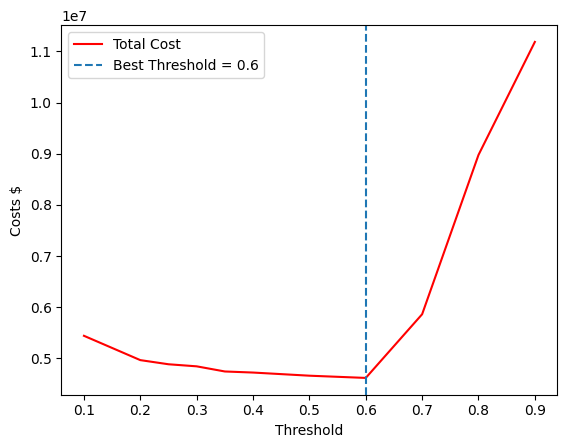

In [522]:
plt.plot(th, total_cost_list, label = 'Total Cost', color = 'red')
plt.axvline(x = th[np.argmin(total_cost_list)], linestyle = '--', label = f'Best Threshold = {th[np.argmin(total_cost_list)]}')
plt.xlabel('Threshold')
plt.ylabel('Costs $')
plt.legend()

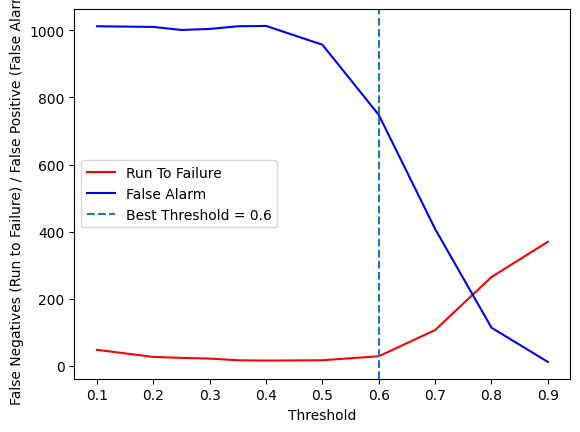

In [523]:
plt.plot(th, FN_list, label = 'Run To Failure', color = 'red')
plt.plot(th, FP_list, label = 'False Alarm', color = 'blue')
plt.axvline(x = th[np.argmin(total_cost_list)], linestyle = '--', label = f'Best Threshold = {th[np.argmin(total_cost_list)]}')


plt.xlabel('Threshold')
plt.ylabel('False Negatives (Run to Failure) / False Positive (False Alarm)')
plt.legend()

#### Evaluating Training with Heuristics

In [524]:
threshold = th[np.argmin(total_cost_list)]
forecasting_window = 7


y_train_pp = X_train_ids.copy()
#y_train_pp = pd.concat([y_train_pp, y_train], axis = 1)
y_train_pp['pred'] = (y_train_pred > threshold).astype(int)
y_train_pp['pred_prob'] = y_train_pred
y_train_pp['target'] = y_train['target'].values.tolist()

y_val_pp = X_val_ids.copy()
#y_val_pp = pd.concat([y_val_pp, y_val], axis = 1)
y_val_pp['pred'] = (y_val_pred > threshold).astype(int)
y_val_pp['pred_prob'] = y_val_pred
y_val_pp['target'] = y_val['target'].values.tolist()

y_oot_pp = X_oot_ids.copy()
#y_val_pp = pd.concat([y_val_pp, y_val], axis = 1)
y_oot_pp['pred'] = (y_oot_pred > threshold).astype(int)
y_oot_pp['pred_prob'] = y_oot_pred
y_oot_pp['target'] = df_oot['target'].values.tolist()

df_train_machine_total = pd.DataFrame()
for machine in y_train_pp['machineID'].unique():
    df_train_machine = y_train_pp[y_train_pp['machineID'] == machine].sort_values('dtRef')
    df_train_machine['pred_sum'] =(df_train_machine['pred'].rolling(min_periods=1, window=(forecasting_window)).sum())
    df_train_machine_total = pd.concat([df_train_machine_total, df_train_machine], axis = 0)
    
df_train_machine_total['real_pred']=np.where((df_train_machine_total.pred_sum>1), 0, df_train_machine_total.pred)



df_val_machine_total = pd.DataFrame()
for machine in y_val_pp['machineID'].unique():
    df_val_machine = y_val_pp[y_val_pp['machineID'] == machine].sort_values('dtRef')
    df_val_machine['pred_sum'] =(df_val_machine['pred'].rolling(min_periods=1, window=(forecasting_window)).sum())
    df_val_machine_total = pd.concat([df_val_machine_total, df_val_machine], axis = 0)
    
df_val_machine_total['real_pred']=np.where((df_val_machine_total.pred_sum>1), 0, df_val_machine_total.pred)



df_oot_machine_total = pd.DataFrame()
for machine in y_oot_pp['machineID'].unique():
    df_oot_machine = y_oot_pp[y_oot_pp['machineID'] == machine].sort_values('dtRef')
    df_oot_machine['pred_sum'] =(df_oot_machine['pred'].rolling(min_periods=1, window=(forecasting_window)).sum())
    df_oot_machine_total = pd.concat([df_oot_machine_total, df_oot_machine], axis = 0)
    
df_oot_machine_total['real_pred']=np.where((df_oot_machine_total.pred_sum>1), 0, df_oot_machine_total.pred)

In [525]:
df_train_machine_filtered = pd.DataFrame()
failures_window = []
for i in range(1, 101):
    df_filt, failure_window = filter_signals(df_train_machine_total, df_failures, i, forecasting_window)
    df_train_machine_filtered = pd.concat([df_train_machine_filtered, df_filt], ignore_index = True)
    failures_window.append(failure_window)


C:\Users\BRUM\AppData\Local\Temp\ipykernel_2496\2409606501.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failure_machine['dtRef'] = pd.to_datetime(failure_machine['dtRef'])
C:\Users\BRUM\AppData\Local\Temp\ipykernel_2496\2409606501.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failure_machine['days_between'] = failure_machine['dtRef'].diff() / pd.Timedelta(days = 1)
C:\Users\BRUM\AppData\Local\Temp\ipykernel_2496\2409606501.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [526]:
df_res = pd.DataFrame()
for machine in df_train_machine_filtered['machineID'].unique():
    TP, FN, FP = evaluate_machines(df_train_machine_filtered, machine)
    res = pd.DataFrame({'machineID': [machine],
                'TP': [TP],
                'FN': [FN],
                'FP': [FP]})
    df_res = pd.concat([df_res, res], ignore_index = True)

C:\Users\BRUM\AppData\Local\Temp\ipykernel_2496\2887940979.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['dtRef_dt'] = pd.to_datetime(sample['dtRef'], format = '%Y-%m-%d')
C:\Users\BRUM\AppData\Local\Temp\ipykernel_2496\2887940979.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['dtRef_dt'] = pd.to_datetime(sample['dtRef'], format = '%Y-%m-%d')
C:\Users\BRUM\AppData\Local\Temp\ipykernel_2496\2887940979.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [527]:
TP = df_res[['TP', 'FN', 'FP']].sum(axis = 0)['TP']
FN = df_res[['TP', 'FN', 'FP']].sum(axis = 0)['FN']
FP = df_res[['TP', 'FN', 'FP']].sum(axis = 0)['FP']


print("TP:",TP)
print("FP:",FP)
print("FN:",FN)

print("Recall:", (TP/(TP + FN)))
print("Precision:", (TP/(TP + FP)))
print("F1-Score:", (TP / (TP + 0.5 * (FP + FN))))


TP: 350
FP: 748
FN: 29
Recall: 0.9234828496042217
Precision: 0.31876138433515483
F1-Score: 0.47393364928909953


In [528]:
# Here, I'm dividing all numbers by 7 because I receive always a window of 7 positive values. So, in practive, only the first one is considered the TRUE positive
# Maybe I'm overestimating this numbers for FP and FN, but it's ok for now.
total_cost_unnecessary_maintenance = unnecessary_maintenance * FP
total_cost_appropriate_maintenance = appropriate_maintenance * TP
total_cost_run_to_failure = run_to_failure * FN
total_cost = total_cost_unnecessary_maintenance + total_cost_appropriate_maintenance + total_cost_run_to_failure

print("total_cost_unnecessary_maintenance: k$", total_cost_unnecessary_maintenance/1e3)
print("total_cost_appropriate_maintenance: k$", total_cost_appropriate_maintenance/1e3)
print("total_cost_run_to_failure: k$", total_cost_run_to_failure/1e3)
print("total_cost k$:", total_cost/1e3)

print('Average Cost per Machine: k$', (total_cost/1e3)/X_train_ids['machineID'].nunique())


total_cost_unnecessary_maintenance: k$ 1122.0
total_cost_appropriate_maintenance: k$ 2625.0
total_cost_run_to_failure: k$ 870.0
total_cost k$: 4617.0
Average Cost per Machine: k$ 67.8970588235294


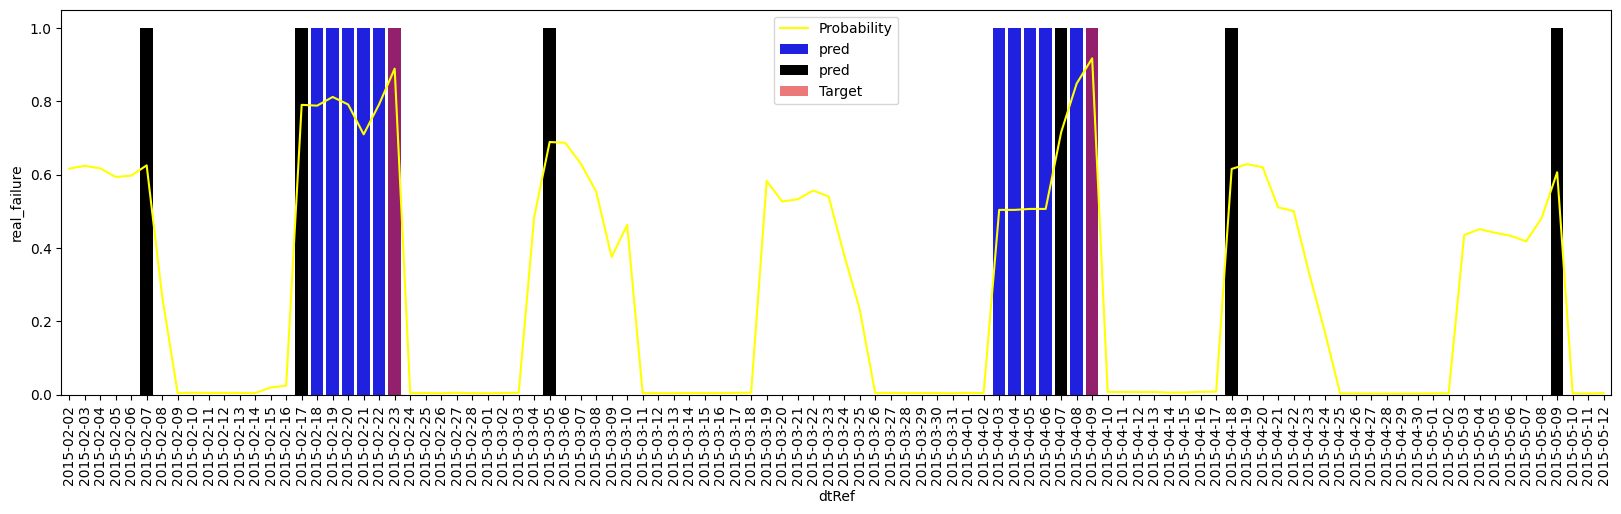

In [529]:
plt.figure(1, figsize = (20,5))
sns.barplot(x = 'dtRef', y = 'target', data = df_train[df_train['machineID'] == 5].iloc[:100], label = 'pred', color = 'blue')
sns.barplot(x = 'dtRef', y = 'real_pred', data = df_train_machine_filtered[df_train_machine_filtered['machineID'] == 5].iloc[:100], label = 'pred', color = 'black')
sns.lineplot(x = 'dtRef', y = 'pred_prob', data = df_train_machine_filtered[df_train_machine_filtered['machineID'] == 5].iloc[:100], label = 'Probability', color = 'yellow')
sns.barplot(x = 'dtRef', y = 'real_failure', data = df_train_machine_filtered[df_train_machine_filtered['machineID'] == 5].iloc[:100], label = 'Target', color = 'red', alpha = 0.6)
plt.xticks(rotation=90)
plt.legend()

#### Evaluating Validation with Heuristics

In [535]:
X_val_ids['machineID'].nunique()

32

In [530]:
#### Evaluating Validation with Heuristics
df_val_machine_filtered = pd.DataFrame()
failures_window = []
for i in X_val_ids['machineID'].unique():
    df_filt, failure_window = filter_signals(df_val_machine_total, df_failures, i, forecasting_window)
    df_val_machine_filtered = pd.concat([df_val_machine_filtered, df_filt], ignore_index = True)
    failures_window.append(failure_window)

df_res = pd.DataFrame()
for machine in df_val_machine_filtered['machineID'].unique()[:5]:
    TP, FN, FP = evaluate_machines(df_val_machine_filtered, machine)
    res = pd.DataFrame({'machineID': [machine],
                'TP': [TP],
                'FN': [FN],
                'FP': [FP]})
    df_res = pd.concat([df_res, res], ignore_index = True)
TP = df_res[['TP', 'FN', 'FP']].sum(axis = 0)['TP']
FN = df_res[['TP', 'FN', 'FP']].sum(axis = 0)['FN']
FP = df_res[['TP', 'FN', 'FP']].sum(axis = 0)['FP']


print("TP:",TP)
print("FP:",FP)
print("FN:",FN)

print("Recall:", (TP/(TP + FN)))
print("Precision:", (TP/(TP + FP)))
print("F1-Score:", (TP / (TP + 0.5 * (FP + FN))))

# Here, I'm dividing all numbers by 7 because I receive always a window of 7 positive values. So, in practive, only the first one is considered the TRUE positive
# Maybe I'm overestimating this numbers for FP and FN, but it's ok for now.
total_cost_unnecessary_maintenance = unnecessary_maintenance * FP
total_cost_appropriate_maintenance = appropriate_maintenance * TP
total_cost_run_to_failure = run_to_failure * FN
total_cost = total_cost_unnecessary_maintenance + total_cost_appropriate_maintenance + total_cost_run_to_failure

print("total_cost_unnecessary_maintenance: k$", total_cost_unnecessary_maintenance/1e3)
print("total_cost_appropriate_maintenance: k$", total_cost_appropriate_maintenance/1e3)
print("total_cost_run_to_failure: k$", total_cost_run_to_failure/1e3)
print("total_cost k$:", total_cost/1e3)

print('Average Cost per Machine: k$', (total_cost/1e3)/X_val_ids['machineID'].nunique())



C:\Users\BRUM\AppData\Local\Temp\ipykernel_2496\2409606501.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['pred'] = (df_final['pred_prob'] > threshold).astype(int)
C:\Users\BRUM\AppData\Local\Temp\ipykernel_2496\2409606501.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['pred_diff'] = (df_final['pred'].diff() > 0).astype(int)
C:\Users\BRUM\AppData\Local\Temp\ipykernel_2496\2409606501.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


TP: 32
FP: 58
FN: 4
Recall: 0.8888888888888888
Precision: 0.35555555555555557
F1-Score: 0.5079365079365079
total_cost_unnecessary_maintenance: k$ 87.0
total_cost_appropriate_maintenance: k$ 240.0
total_cost_run_to_failure: k$ 120.0
total_cost k$: 447.0
Average Cost per Machine: k$ 13.96875


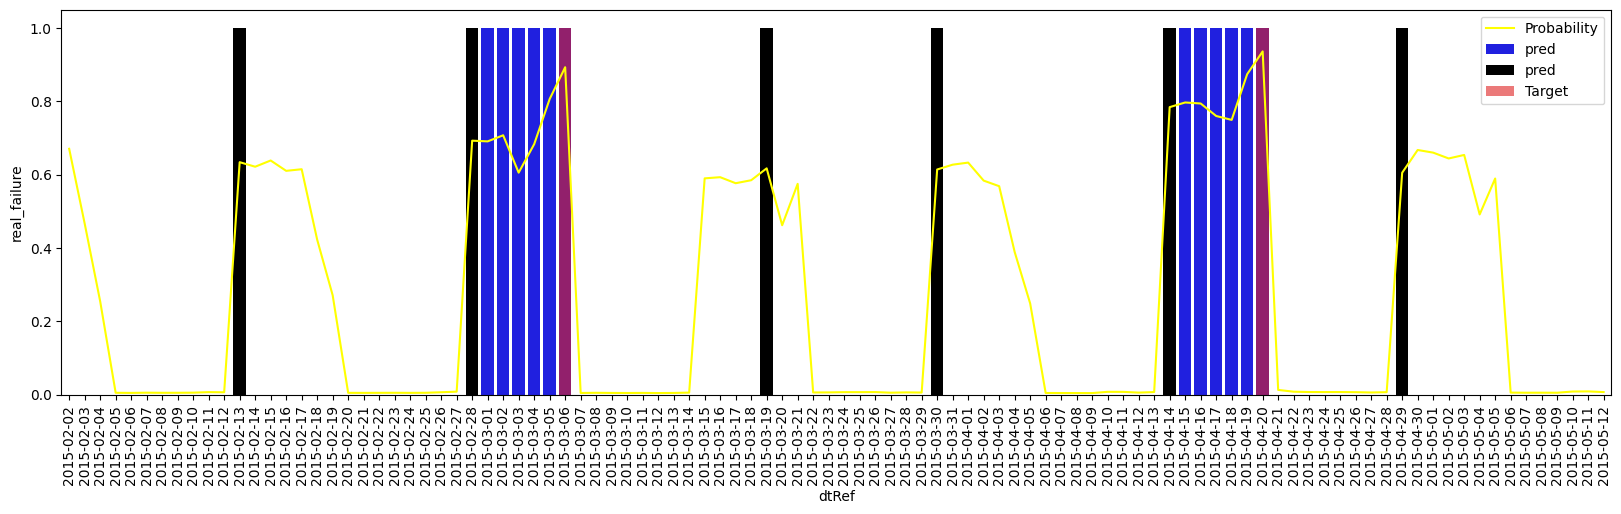

In [531]:
plt.figure(1, figsize = (20,5))
sns.barplot(x = 'dtRef', y = 'target', data = df_train[df_train['machineID'] == 1].iloc[:100], label = 'pred', color = 'blue')
sns.barplot(x = 'dtRef', y = 'real_pred', data = df_val_machine_filtered[df_val_machine_filtered['machineID'] == 1].iloc[:100], label = 'pred', color = 'black')
sns.lineplot(x = 'dtRef', y = 'pred_prob', data = df_val_machine_filtered[df_val_machine_filtered['machineID'] == 1].iloc[:100], label = 'Probability', color = 'yellow')
sns.barplot(x = 'dtRef', y = 'real_failure', data = df_val_machine_filtered[df_val_machine_filtered['machineID'] == 1].iloc[:100], label = 'Target', color = 'red', alpha = 0.6)
plt.xticks(rotation=90)
plt.legend()

#### Evaluating Out of Time with Heuristics

In [532]:
#### Evaluating Validation with Heuristics
df_oot_machine_filtered = pd.DataFrame()
failures_window = []
for i in X_val_ids['machineID'].unique():
    df_filt, failure_window = filter_signals(df_oot_machine_total, df_failures, i, forecasting_window)
    df_oot_machine_filtered = pd.concat([df_oot_machine_filtered, df_filt], ignore_index = True)
    failures_window.append(failure_window)

df_res = pd.DataFrame()
for machine in df_oot_machine_filtered['machineID'].unique():
    TP, FN, FP = evaluate_machines(df_oot_machine_filtered, machine)
    res = pd.DataFrame({'machineID': [machine],
                'TP': [TP],
                'FN': [FN],
                'FP': [FP]})
    df_res = pd.concat([df_res, res], ignore_index = True)
TP = df_res[['TP', 'FN', 'FP']].sum(axis = 0)['TP']
FN = df_res[['TP', 'FN', 'FP']].sum(axis = 0)['FN']
FP = df_res[['TP', 'FN', 'FP']].sum(axis = 0)['FP']


print("TP:",TP)
print("FP:",FP)
print("FN:",FN)

print("Recall:", (TP/(TP + FN)))
print("Precision:", (TP/(TP + FP)))

# Here, I'm dividing all numbers by 7 because I receive always a window of 7 positive values. So, in practive, only the first one is considered the TRUE positive
# Maybe I'm overestimating this numbers for FP and FN, but it's ok for now.
total_cost_unnecessary_maintenance = unnecessary_maintenance * FP
total_cost_appropriate_maintenance = appropriate_maintenance * TP
total_cost_run_to_failure = run_to_failure * FN
total_cost = total_cost_unnecessary_maintenance + total_cost_appropriate_maintenance + total_cost_run_to_failure

print("total_cost_unnecessary_maintenance: k$", total_cost_unnecessary_maintenance/1e3)
print("total_cost_appropriate_maintenance: k$", total_cost_appropriate_maintenance/1e3)
print("total_cost_run_to_failure: k$", total_cost_run_to_failure/1e3)
print("total_cost k$:", total_cost/1e3)

print('Average Cost per Machine: k$', (total_cost/1e3)/df_oot_machine_filtered['machineID'].nunique())



C:\Users\BRUM\AppData\Local\Temp\ipykernel_2496\2409606501.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['pred'] = (df_final['pred_prob'] > threshold).astype(int)
C:\Users\BRUM\AppData\Local\Temp\ipykernel_2496\2409606501.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['pred_diff'] = (df_final['pred'].diff() > 0).astype(int)
C:\Users\BRUM\AppData\Local\Temp\ipykernel_2496\2409606501.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


TP: 4
FP: 15
FN: 1
Recall: 0.8
Precision: 0.21052631578947367
total_cost_unnecessary_maintenance: k$ 22.5
total_cost_appropriate_maintenance: k$ 30.0
total_cost_run_to_failure: k$ 30.0
total_cost k$: 82.5
Average Cost per Machine: k$ 2.578125


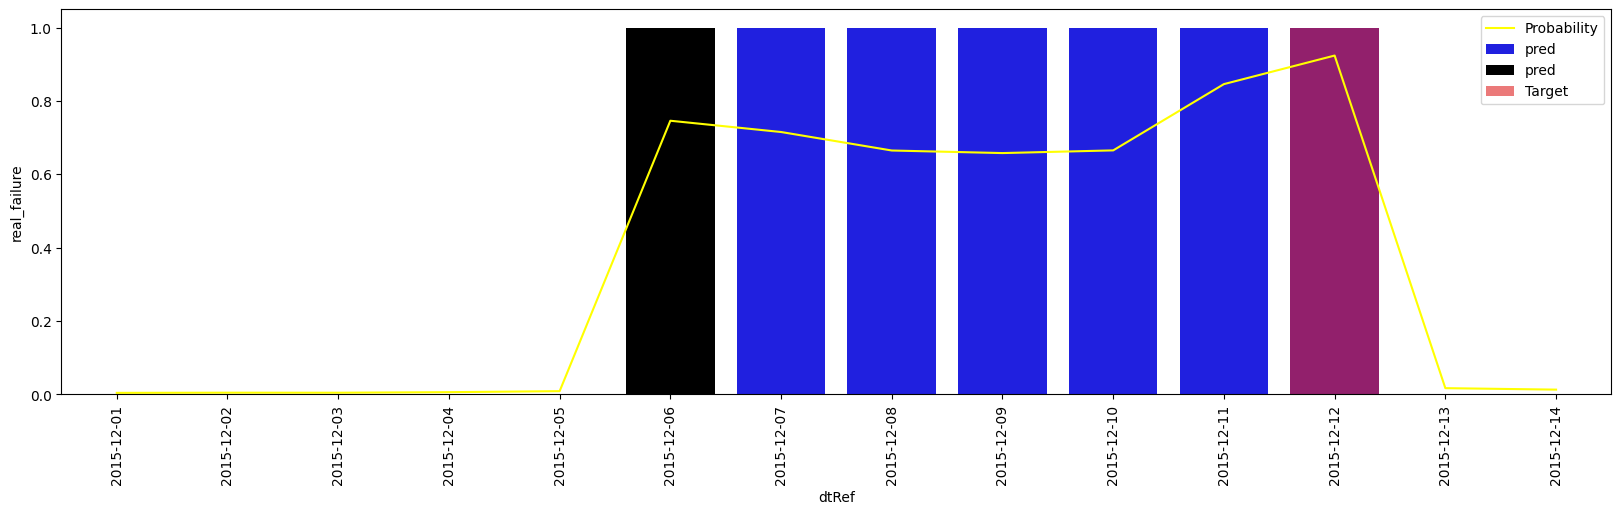

In [533]:
plt.figure(1, figsize = (20,5))
sns.barplot(x = 'dtRef', y = 'target', data = df_oot[df_oot['machineID'] == 51].iloc[:100], label = 'pred', color = 'blue')
sns.barplot(x = 'dtRef', y = 'real_pred', data = df_oot_machine_filtered[df_oot_machine_filtered['machineID'] == 51].iloc[:100], label = 'pred', color = 'black')
sns.lineplot(x = 'dtRef', y = 'pred_prob', data = df_oot_machine_filtered[df_oot_machine_filtered['machineID'] == 51].iloc[:100], label = 'Probability', color = 'yellow')
sns.barplot(x = 'dtRef', y = 'real_failure', data = df_oot_machine_filtered[df_oot_machine_filtered['machineID'] == 51].iloc[:100], label = 'Target', color = 'red', alpha = 0.6)
plt.xticks(rotation=90)
plt.legend()